# Sampling Methods

### Table of Contents
1. [Monte Carlo](#monte-carlo)
2. [Markov Chain Monte Carlo](#markov-chain-monte-carlo)
3. [Metropolis-Hastings](#metropolis-hastings)
4. [Gibbs sampling](#gibbs-sampling)
5. [Rejection sampling](#rejection-sampling)
6. [Importance sampling](#importance-sampling)
7. [References](#references)

## Monte Carlo <a class="anchor" id="monte-carlo"></a>

Monte Carlo integration is a basic Monte Carlo method for numerically estimating the integration of a function $f(x)$.

Suppose we want to solve the integration of $f(x)$ over a domain $D$:

$\int_{x \in D} f(x) \,dx = \int_{x \in D} \frac{f(x)}{p(x)}  p(x) \,dx = $
$\int_{x \in D} g(x)p(x) \,dx = E[g(x)] $

$E[g(x)] \approx \frac{1}{N} \sum_{i=1}^{N} \frac{f(x)}{p(x)}$

Suppose that $p$ is the uniform distribution. We will try to approximate $\int_{3}^{3} f^2(x) \, dx$:

In [54]:
import numpy as np

def func1(x):
    # function f(x)=x^2
    return x**2

def func1_int(a, b):
    # analytical solution to integral of f(x)
    return (1/3)*(b**3-a**3)
  
def mc_integrate(func, a, b, n = 1000):
    # Monte Carlo integration between x1 and x2 of given function from a to b
    
    vals = np.random.uniform(a, b, n)
    y = [func(val) for val in vals]
    
    y_mean = np.sum(y)/n
    integ = (b-a) * y_mean
    
    return integ

print(f"Monte Carlo solution: {mc_integrate(func1, -3, 3, 500000): .4f}")
print(f"Analytical solution: {func1_int(-3, 3): .4f}")


Monte Carlo solution:  18.0223
Analytical solution:  18.0000


## Markov Chain Monte Carlo  <a class="anchor" id="markov-chain-monte-carlo"></a>

However, there are times when direct sampling from a distribution is not possible. Suppose we wish to sample from $P(x)$, $P(x)=\frac{f(x)}{K}$

Here we know $f(x)$, but $K$ can be difficult to estimate. As a result, we do not know what $P(x)$ looks like. We cannot directly sample from something we do not know.


**Markov chain Monte Carlo** (MCMC) is a class of algorithms that addresses this by allowing us to estimate $P(x)$ even if we do not know the distribution, by using a function $f(x)$ that is proportional to the target distribution $P(x)$.

How MCMC solves this is by constructing a Markov chain of $x$ values such that the stationary distribution of the chain $\pi(x)$ is equal to $P(x)$. With some derivation, we can show the following general steps,

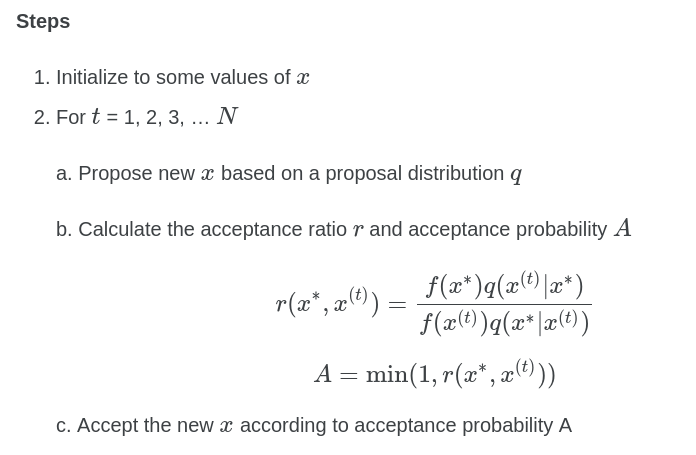


**MCMC** is particularly useful in **Bayesian inference** where we would like to know the posterior estimate of our model parameters — i.e. what is the confidence range of the parameters $θ$, given observed data $X$.

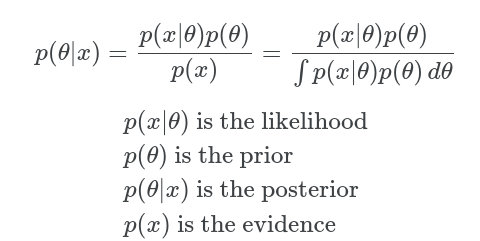

What the Bayes’ theorem says is that in order to calculate the posterior $p(θ|X)$, we need to calculate the product of the likelihood $p(X|θ)$ and the prior $p(θ)$ over a normalizing factor (the evidence). But the integral term for the normalizing factor is often complicated and unknown. But notice that the posterior is proportional to the product of the likelihood and prior,


$p(θ|x)∝p(x|θ)p(θ)$


This is exactly similar to the expression $P(x)=\frac{f(x)}{K}$ discussed in the earlier section. Thus, the steps to apply MCMC is exactly the same — we will change the notations to that in the context of Bayesian inference,

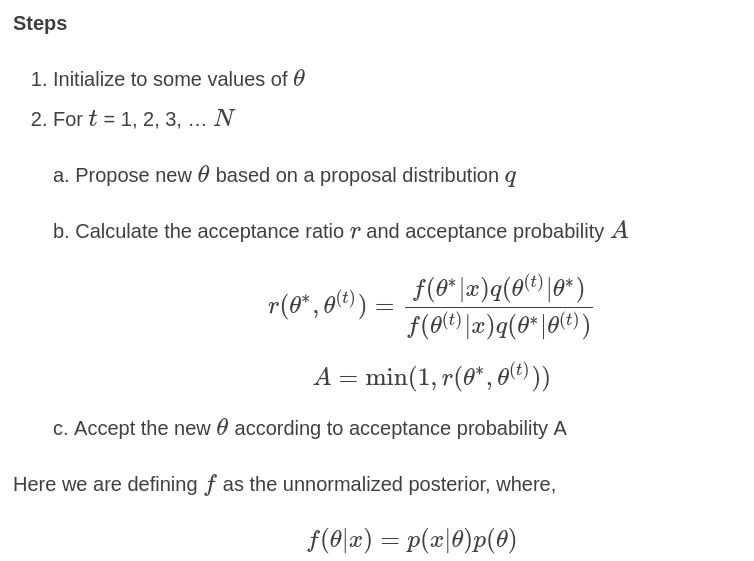

## Metropolis-Hastings  <a class="anchor" id="metropolis-hastings"></a>

Metropolis-Hastings is a specific implementation of MCMC. It works well in high dimensional spaces as opposed to Gibbs sampling and rejection sampling.

Metropolis-Hastings uses $N$ to randomly walk in the distribution space, accepting or rejecting jumps to new positions based on how likely the sample is. 

The “likelihood” of each new sample is decided by a function $f$ . That’s why $f$ must be proportional to the posterior we want to sample from. $f$ is commonly chosen to be a probability density function that expresses this proportionality.

With many data samples, the likelihood term $p(X|θ)$ is the product of all the $p(X_i|θ)$ likelihoods (of each sample). Multiplying many probabilities for simulation will lead to very small numbers. Instead, for numerical stability during computational simulation, we need to use the log transform instead. This means we are calculating the log of unnormalized posterior,


$ln \, p(θ|x)∝ln \, p(x|θ)p(θ)$


The example uses:
 - Data generated  $ \sim N(3, 1)$
 - Gaussian likelihood and the prior $ \sim N(0, 1)$. This means that the posterior is also a Gaussian.
 - We will set our proposal distribution as a Gaussian distribution centered as the current proposed $θ$. 
 - The standard deviation of this proposal distribution describes then how far the new $θ^∗$ proposal is likely to be from the current proposed $θ$.
 - Since the proposal distribution is symmetric, the MH algorithm below technically reduces to the Metropolis algorithm. 

In [55]:
import numpy as np
import scipy.stats as st

def guassian_posterior(X, theta):
    # returns the unnormalized log posterior
    loglik = np.sum(np.log(st.norm(loc=theta, scale=1).pdf(X)))
    logprior = np.log(st.norm(loc=0, scale=1).pdf(theta))
    
    return loglik + logprior

def guassian_proposal(theta_curr):
    # proposal based on Gaussian
    theta_new = st.norm(loc=theta_curr, scale=0.2).rvs()
    return theta_new

def guassian_proposal_prob(x1, x2):
    # calculate proposal probability q(x2|x1), based on Gaussian
    q = st.norm(loc=x1, scale=1).pdf(x2)
    return q

def mcmc_mh_posterior(X, theta_init, posterior_func, proposal_func, proposal_func_prob, N=1000):
    # Metropolis-Hastings to estimate posterior
    thetas = []
    theta_curr = theta_init
    accept_rates = []
    accept_cum = 0
    
    for i in range(1, N+1):
        theta_new = proposal_func(theta_curr)
        
        prob_curr = posterior_func(X, theta_curr)
        prob_new = posterior_func(X, theta_new)
        
        # we calculate the prob=exp(x) only when prob<1 so the exp(x) will not overflow for large x
        if prob_new > prob_curr:
            acceptance_ratio = 1
        else:
            qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_curr, theta_new)
            acceptance_ratio = np.exp(prob_new - prob_curr) * qr
        acceptance_prob = min(1, acceptance_ratio)
        
        if acceptance_prob > st.uniform(0,1).rvs():
            theta_curr = theta_new
            accept_cum = accept_cum+1
            thetas.append(theta_new)
        else:
            thetas.append(theta_curr)
            
        accept_rates.append(accept_cum/i)
        
    return thetas, accept_rates



Mean acceptance rate:  0.217


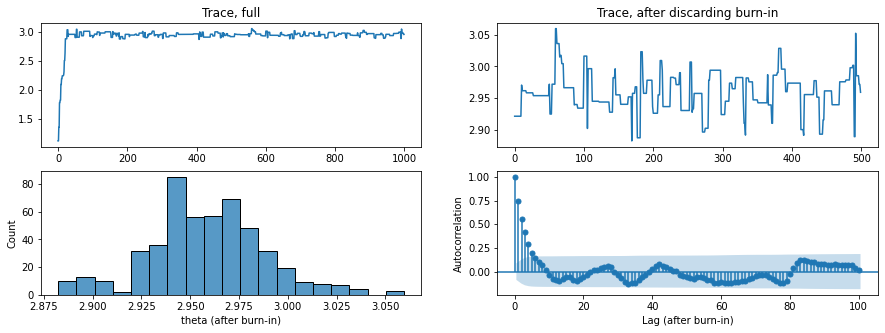

In [56]:
# generate observed data X∼N(3,1).
X = st.norm(loc=3, scale=1).rvs(size=1000)

# run MCMC
thetas, accept_rates = mcmc_mh_posterior(X, 1, 
                                         guassian_posterior, guassian_proposal, guassian_proposal_prob, 
                                         N=1000)

plot_res(thetas, 500, 'theta')
print(f"Mean acceptance rate: {np.mean(accept_rates[50:]): .3f}")

## Gibbs sampling <a class="anchor" id="gibbs-sampling"></a>

Monte Carlo methods are essentially about sampling from distributions, and calculating integrals,

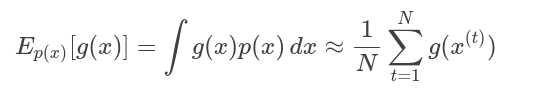

n this above equation, we want to approximate the expected value of $g(x)$ with random variable $X$ that is of distribution $p(x)$.

**MCMC is designed when we cannot directly sample from $p(x)$**. Instead we sample from a distribution proportional to it, with the resulting stationary distribution of the Markov chain equaling to $p(x)$.

When the $p(x)$ is multivariate:
 - **Metropolis-Hastings algorithm**: we would draw from a proposal distribution that is a joint distribution (to propose simultaneously the new values for x1, x2, etc). 
 - **Gibbs sampling**: we sample from full conditional distributions, e.g. $p(x1|x−1)$. 
 
The end result is the same - we have an approximation of the joint distribution $p(x)$.


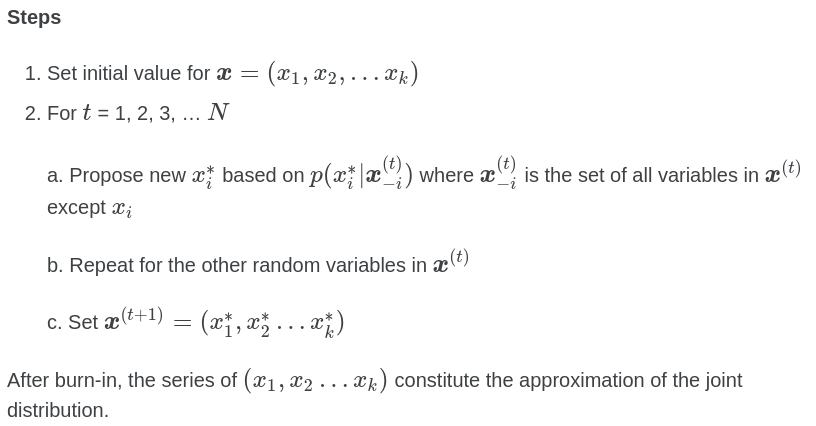

**Gibbs sampling is a special case of the Metropolis-Hastings algorithm**. Given the acceptance ratio in MH,

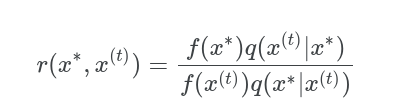

with Gibbs sampling, our f(x) is a probability distribution p(x) and our proposal distribution is the full conditional distributions of p(x). At each proposal step, the acceptance ratio is essentially,

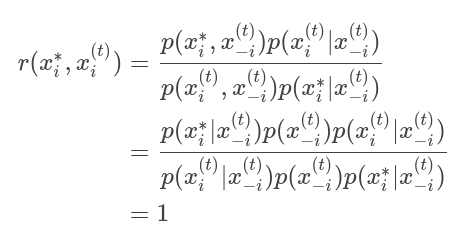

Hence with **Gibbs sampling, it is a MH algorithm with acceptance ratio always equaling to 1.**



**Gibbs Sampling pros:**
 - proposals are always accepted
 - Gibbs sampling was introduced was to break the curse of dimensionality (which impacts both rejection and importance sampling) 
 - Gibbs sampling is favoured in settings where the decomposition into conditionals is easy to implement and fast to run.
**Gibbs Sampling cons:**
 -  we need to be able to derive the above conditional probability distributions. This is tractable when $P(\theta_d)$ is conjugate to the posterior.
 - In settings where such decompositions induce multimodality and hence a difficulty to move between modes (latent variable models like mixture models come to mind), using a more global proposal in a Metropolis-Hasting algorithm may produce a higher efficiency. But the drawback stands with choosing the proposal distribution in the Metropolis-Hasting algorithm.

In [57]:
class guassian_prob:
    # class for sampling from conditional Gaussian distribution
    
    def __init__(self, mu: np.ndarray, cov: np.ndarray):
        # initialize with mean and covariance matrix
        
        # take care of some typing
        mu = np.array(mu) if type(mu) is list else mu
        cov = np.array(cov) if type(cov) is list else cov
        
        self.mu = mu
        self.cov = cov
        
    def sample_conditional(self, x: np.ndarray, idx: list):
        # sampling from a conditional distribution
        # given X, and draw from p(X_idx | X_rest), where idx is index in array X
        
        # take care of some typing
        idx = [idx] if type(idx) is int else idx
        x = [x] if type(x) is int else x
        x = np.array(x) if type(x) is list else x
        
        # get the indices of variables to be conditioned on
        idx_not = [i for i in list(range(len(self.mu))) if i not in idx]
        
        # get the matrix components
        mu1 = self.mu[idx]
        mu2 = self.mu[idx_not]
        cov11 = self.cov[np.ix_(idx, idx)]
        cov22 = self.cov[np.ix_(idx_not, idx_not)]
        cov12 = self.cov[np.ix_(idx, idx_not)]
        cov21 = self.cov[np.ix_(idx_not, idx)]
        a = x[idx_not]
        
        # calculate conditional matrices
        mu_cond = mu1 + np.matmul(np.matmul(cov12, np.linalg.inv(cov22)), (a - mu2))
        cov_cond = cov11 - np.matmul(np.matmul(cov12, np.linalg.inv(cov22)), cov21)
        
        x_new = st.multivariate_normal(mu_cond, cov_cond).rvs()
        
        return x_new
    
    def sample(self, n):
        # direct sampling of the joint distribution
        return st.multivariate_normal(mean=mu, cov=cov).rvs(n)


def mcmc_gibbs(prob_func, x_init, n_iter=1000):
    # Gibbs sampling, given a conditional distribution function (class)
    
    xs = []
    x_sample = x_init # initial x values
    
    for i in range(n_iter):
        for j in range(len(x_sample)):
            x_sample[j] = prob_func.sample_conditional(x_sample, j)

        xs.append(x_sample.copy())
        
    return np.vstack(xs)



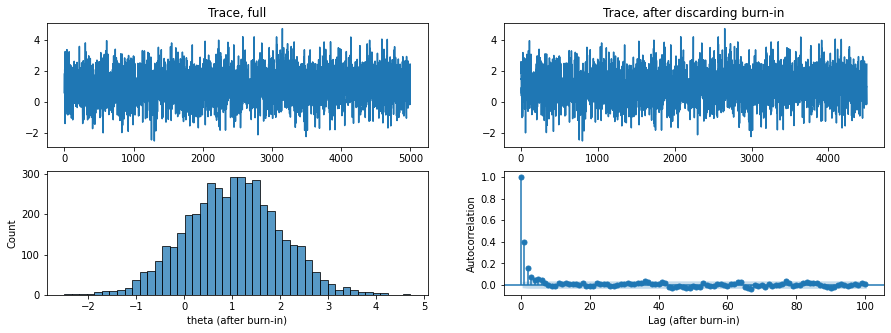

In [58]:
np.random.seed(10)

mu = np.array([-2, 1])
sigma = np.array([[1, 0.8], [0.8, 1]])
cov = np.power(sigma, 2)

prob = guassian_prob(mu, cov)
xs = mcmc_gibbs(prob, [0,0], n_iter=5000)

x1 = [v[1] for v in xs]
plot_res(x1, 500, 'theta')

## Rejection sampling <a class="anchor" id="rejection-sampling"></a>

As with MCMC method like Metropolis-Hastings and Gibbs Sampling, **Rejection Sampling** is used to draw samples from a complicated target distribution where direct sampling is hard. 

This can be done by using a proposal distribution $Q(x)$ that is easy to sample from. This $Q(x)$ has to have an important property, namely, $Q(x$ has to envelope the target distribution $P(x)$. That means, given a scaling factor $k$, it has to be $kQ(x) > P(x)$. for all $x$. In other word, our target distribution has to be entirely under our scaled proposal distribution.

If we do Rejection Sampling on this $Q(x)$ naively, it will surely failed, as those high probability areas of $P(x)$ aren’t covered by $Q(x)$. Intuitively, the acceptance rate will be lower if $Q(x)$ isn’t enveloping $P(x)$, which resulting in having a lot less samples in those high probability areas than it should.

To remedy that, we need to find scaling factor $k$, so that $kQ(x)$ will envelop $P(x)$ entirely. To find it, we need to get the maximum ratio of $P(x)$ and $Q(x)$. So it will just be $k = max(P(x) / Q(x))$ for all $x$.

The main sampling algorithm is to produce a lot of samples from proposal distribution $Q(x)$, $z \sim Q(x)$, then uniformly pick the height of the distribution, so that it will be $u ~ Unif(0, kQ(z))$. Now that sample of $(z, u)$ will be uniform under the $kQ(x)$ curve. Then, we should just need to evaluate the height of our target distribution $P(x)$ at point $z$. And then very intuitively, we accept $(z, u)$ samples that are under the $P(x)$ curve.

Given a long time to run and generating samples, then it will converge to $P(x)$. 

**Rejection Sampling pros:**
 - Simple
**Rejection Sampling cons:**
 - We have to have pretty good heuristic on choosing the proposal distribution Q(x). 
 - It has to envelope the target distribution. Given a complicated target distribution, it’s hard to know the shape, and it’s hard to choose the proposal distribution.
 - When computing the scaling factor, we have to be careful to make it “just enough” enveloping the target distribution, as the rejection rate will be proportional to the ratio of P(x) and Q(x). 
 - Having a really big $Q(x)$ sure envelop the $P(x)$, but it also means that there are a lot of wasted space that the algorithm will reject, which means a wasted computational time.


k =  3.9146256816520806


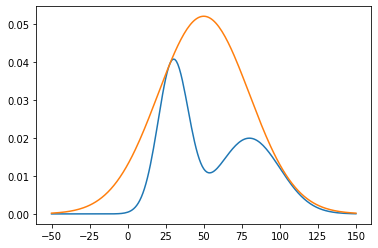

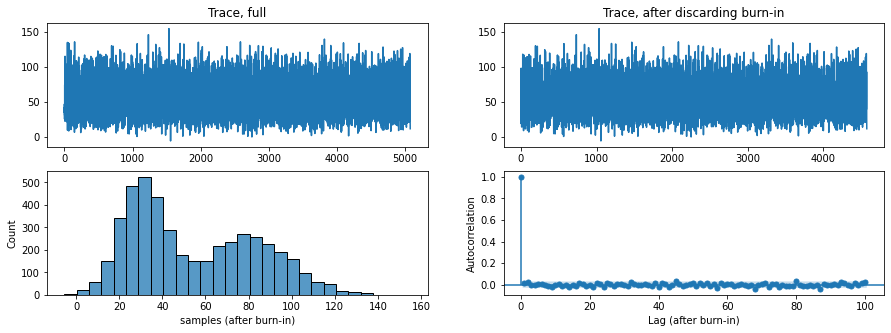

In [59]:
def p(x):
    # The target distribution that I want to sample here is a mixture of Gaussian: N(30, 10) + N(80, 20)
    return st.norm.pdf(x, loc=30, scale=10) + st.norm.pdf(x, loc=80, scale=20)


def q(x):
    return st.norm.pdf(x, loc=50, scale=30)


x = np.arange(-50, 151)
k = max(p(x) / q(x))


def rejection_sampling(iter=1000):
    samples = []

    for i in range(iter):
        z = np.random.normal(50, 30)
        u = np.random.uniform(0, k*q(z))

        if u <= p(z):
            samples.append(z)

    return np.array(samples)

print("k = ", k)
plt.plot(x, p(x))
plt.plot(x, k*q(x))
plt.show()

samples = rejection_sampling(iter=10000)
plot_res(samples, 500, 'samples')

## Importance sampling <a class="anchor" id="importance-sampling"></a>

***Importance sampling*** is a method for reducing the variance of a Monte Carlo simulation without increasing the number of samples. The idea is that instead of randomly sampling from the whole function, let’s just sample from a distribution of points similarly shaped to the function.


Using sampling to approximate a distribution
$$E[f(x)] = \int f(x)p(x) dx \approx \frac{1}{n}\sum_{i} f(x_i)$$

where $ x \sim p(x)$
$$E[f(x)] = \int f(x)p(x) dx = \int f(x)\frac{p(x)}{q(x)}q(x) dx \approx \frac{1}{n} \sum_{i} f(x_i)\frac{p(x_i)}{q(x_i)}$$

where $ x \sim q(x)$

Idea of importance sampling: draw the sample from a proposal distribution and re-weight the integral using importance weights so that the correct distribution is targeted
$$Var(X) = E[X^2] - E[X]^2$$

In [60]:
import scipy.stats as stats

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def distribution(mu=0, sigma=1):
    # return probability given a value
    distribution = stats.norm(mu, sigma)
    return distribution

def importance_sampling(target, p_x, q_x, mu_appro, sigma_appro, n = 1000):
    samples = []
    
    for i in range(n):
        x_i = np.random.normal(mu_appro, sigma_appro)
        value = target(x_i)*(p_x.pdf(x_i) / q_x.pdf(x_i))
        samples.append(value)
    
    return samples

/home/bcebere/anaconda3/envs/vds/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bcebere/anaconda3/envs/vds/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


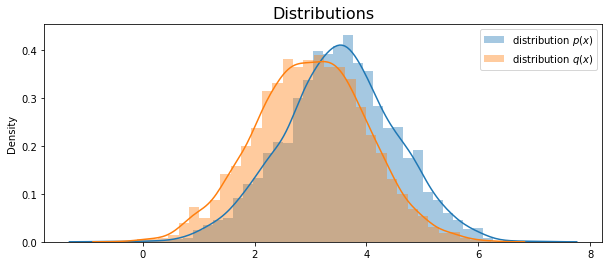

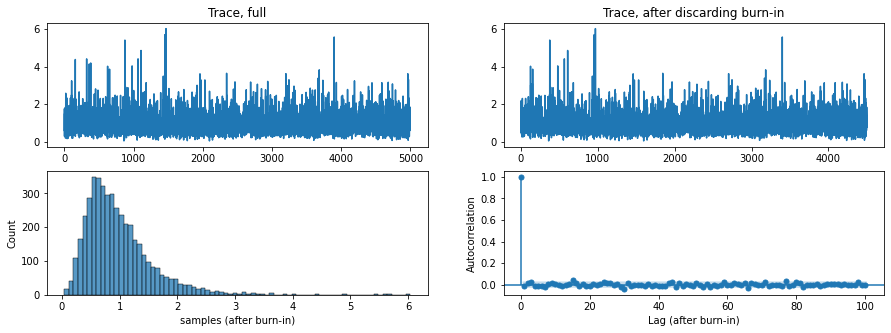

In [61]:
mu_target = 3.5
sigma_target = 1
mu_appro = 3
sigma_appro = 1

p_x = distribution(mu_target, sigma_target)
q_x = distribution(mu_appro, sigma_appro)



plt.figure(figsize=[10, 4])

sns.distplot([np.random.normal(mu_target, sigma_target) for _ in range(3000)], label="distribution $p(x)$")
sns.distplot([np.random.normal(mu_appro, sigma_appro) for _ in range(3000)], label="distribution $q(x)$")

plt.title("Distributions", size=16)
plt.legend()


samples = importance_sampling(sigmoid, p_x, q_x, mu_appro, sigma_appro, n = 5000)
plot_res(samples, 500, 'samples')

## References <a class="anchor" id="references"></a>

1. https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a
2. https://github.com/naturale0/NLP-Do-It-Yourself/blob/main/NLP_with_PyTorch/3_document-embedding/3-1.%20latent%20dirichlet%20allocation.ipynb
3. https://towardsdatascience.com/bayesian-statistics-metropolis-hastings-from-scratch-in-python-c3b10cc4382d
4. https://boyangzhao.github.io/posts/mcmc-bayesian-inference
5. https://boyangzhao.github.io/posts/mcmc-gibbs-sampling-multivariate
6. https://wiseodd.github.io/techblog/2015/10/21/rejection-sampling/